In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / 'util/'))
from qubit_templates import *
from functions import *

# Read configuration file

In [ ]:
wafertype = "silicon" # silicon or sapphire
JJtype = "dolan" # manhattan or dolan
Squid = True

outname = "waferdesign_3D_" + wafertype + "_" + JJtype + "_photolitho"

common_config = load_config( f"config/common_3D.yaml" )
config = load_config( f"config/JJ/{JJtype}_3D_photolitho.yaml" )
config = {**common_config, **config} # common config will be overwritten by value in the right 

config/common.yaml


# Wafer design

In [4]:
wafer = device_Wafer(config)

# Chip design

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


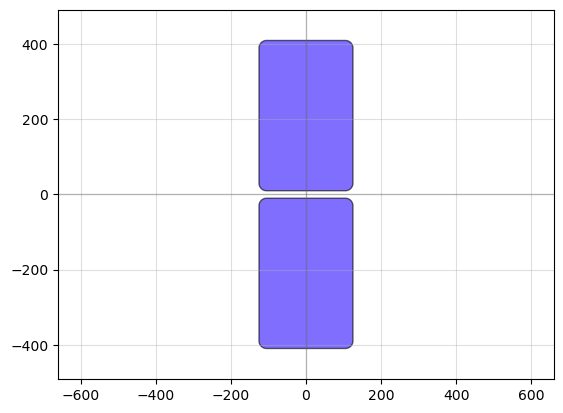

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


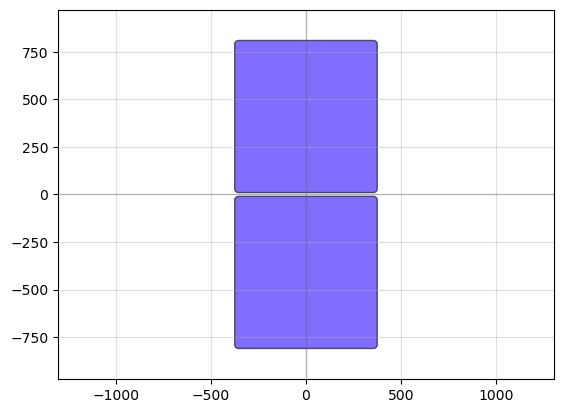

In [5]:
chipdesign = {}
for size in ['S','L']:
    chipdesign[size] = Device(f'chipdesign_{size}')

    PAD=Device('PAD')
    if size == 'L':
        rectangle = pg.rectangle(( 3*config["Pad_width"], 2.*config["Pad_height"]), config["Pad_layer"])
    else:
        rectangle = pg.rectangle(( config["Pad_width"], config["Pad_height"]), config["Pad_layer"])

    rectangle.polygons[0].fillet( config["Pad_rounding"] )
    PAD.add_ref( rectangle ).movex(0).movey(0.5*config["Pad_gap"])
    PAD.add_ref( rectangle ).mirror(p1 = (0, 0), p2 = (200, 0)).movex(0).movey(-0.5*config["Pad_gap"])
    PAD.center = (0, 0)

    chipdesign[size].add_ref(PAD)


    # Quickplot the imported design
    qp(chipdesign[size])


# Josephson Junction

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


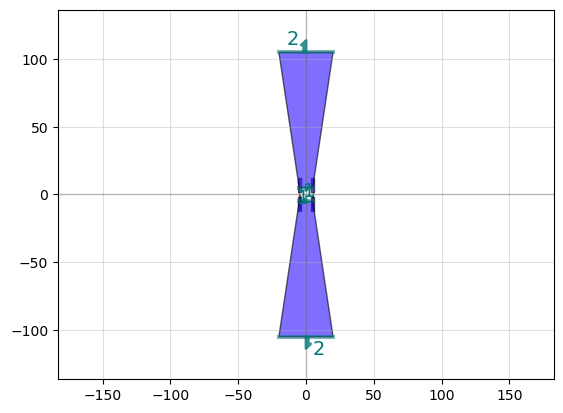

In [6]:
JJ = device_JJ(config)
qp(JJ)

# Add JJ to chip design

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


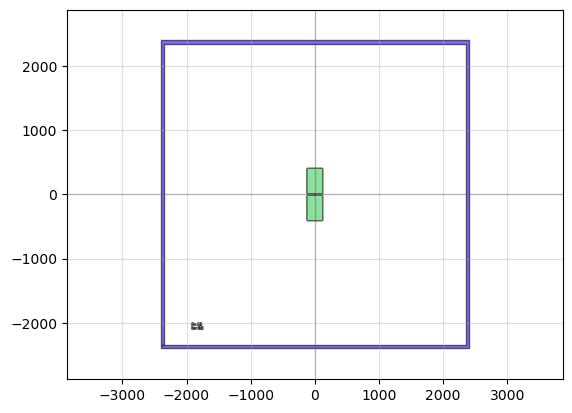

'output/chipdesign_3D.gds'

In [7]:
def custom_chip(width, height, padsize = 'S'):
    chip = Device('chip')
    chip.add_ref(chipdesign[padsize])

    JJ = device_JJ( config )
    chip.add_ref(JJ)

    chip = pg.union( chip )
    for pol in chip.polygons: # unions are separated in dolan structure, so loop through all polygons
        pol.fillet( config["Pad_JJ_rounding"] )
    chip = pg.union( chip )

    text = eval(config["Text_string"], {"width": width, "height": height})
    move_x = config["Text_pos_x"]*0.5*config["Frame_size_width"]
    move_y = config["Text_pos_y"]*0.5*config["Frame_size_height"]

    T = pg.text(text, size=40, layer = config["Text_layer"])
    T.move([move_x,move_y])
    chip.add_ref(T)

    FM=device_Frame(config)
    chip.add_ref(FM)

    return chip

chip = custom_chip(width = 1.0, height = 0.2)
qp(chip)
chip.write_gds('output/chipdesign_3D')

# Place chip designs

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Device (name "grid" (uid 9704), ports [], aliases [], 0 polygons, 32 references)


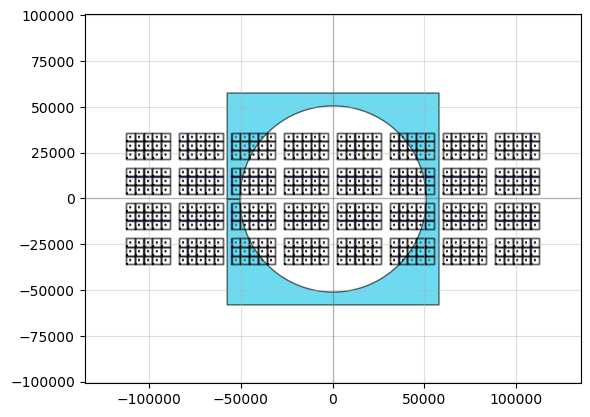

In [8]:
def custom_design(size_x, size_y,  width, height, padsize):

    design = pg.gridsweep(
        function = custom_chip,
        param_x = {'width'  : width },
        param_y = {'height' : height },
        spacing = (0, 0),
        param_defaults = {'padsize' : padsize},
        label_layer = None
        )
    design.center = (0,0)
    return design

if wafertype == "sapphire":
    D = pg.gridsweep(
            function = custom_design,
            param_x = {'width' : config["Grid_finger_width"] },
            param_y = {'height' : config["Grid_finger_height"] },
            param_defaults = {'size_x' : config["Frame_size_width"], 'size_y' : config["Frame_size_height"]},
            spacing = (config["Frame_size_width"] * (len(config["Grid_finger_width"][0]) + config["Grid_gap_x"]), config["Frame_size_height"] * (len(config["Grid_finger_height"][0]) + config["Grid_gap_y"])),
            separation = False,
            label_layer = None
            )
    # D.center = ( - 0.5 * len(Grid_bridge_width) * Chip_size_x * (len(Grid_bridge_width[0]) + Grid_gap_x) ,0)
    D.center = ( 0 ,0)
    wafer.add_ref(D)

    # D = pg.gridsweep(
    #         function = custom_design,
    #         param_x = {'bridge_width' : Grid_small_bridge_width },
    #         param_y = {'finger_width' : Grid_small_finger_width },
    #         param_defaults = {'size_x' : Chip_small_size_x, 'size_y' : Chip_small_size_y},
    #         spacing = (Chip_small_size_x * (len(Grid_small_bridge_width[0]) + Grid_small_gap_x), Chip_small_size_y * (len(Grid_small_finger_width[0]) + Grid_small_gap_y)),
    #         separation = False,
    #         label_layer = None
    #         )
    # D.center = ( 0.5 * len(Grid_small_bridge_width) * Chip_small_size_x * (len(Grid_small_bridge_width[0]) + Grid_small_gap_x) ,0)


    # wafer.add_ref(D)
    qp(D)

else:
    D = pg.gridsweep(
            function = custom_design,
            param_x = {'padsize' : config["Grid_pad_size"], 'width' : config["Grid_finger_width"]}, # Later dictionary iterates first
            param_y = {'height' : config["Grid_finger_height"] }, 
            param_defaults = {'size_x' : config["Frame_size_width"], 'size_y' : config["Frame_size_height"]},            
            spacing = (config["Frame_size_width"]*config["Grid_gap_x"], config["Frame_size_height"]*config["Grid_gap_y"]),
            #separation = False,
            label_layer = None
            )
    print(D)

    # island_width = len(Grid_finger_width[0]) * Chip_size_x 
    # island_height = len(Grid_finger_height[0]) * Chip_size_y     
    # island_gap_width = Chip_size_x * Grid_gap_x
    # island_gap_height = Chip_size_y * Grid_gap_y    
    # D.movex( - 3.5 * (island_width + island_gap_width) )
    # D.movey( - 1.5 * (island_height + island_gap_height) )  
    D.center = (0, 0)  
    wafer.add_ref(D)

    qp(wafer)

# Place dicing marker

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


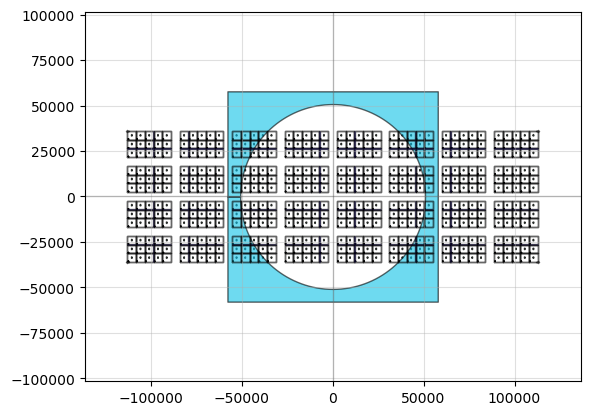

In [9]:
if wafertype == "sapphire":

    DicingMarker = device_DicingMarkers(config)

    spacing_x = config["Frame_size_width"] * config["Grid_gap_x"] * (len(config["Grid_finger_width"]) - 1) + config["Frame_size_width"] * len(config["Grid_finger_width"]) * len(config["Grid_finger_width"][0])
    spacing_y = config["Frame_size_height"] * config["Grid_gap_y"] * (len(config["Grid_finger_height"]) - 1) + config["Frame_size_height"] * len(config["Grid_finger_height"]) * len(config["Grid_finger_height"][0])

    # wafer.add_ref(DicingMarker).center = (0, 0)

    wafer.add_ref(DicingMarker).center = (-0.5*spacing_x, -0.5*spacing_y)
    wafer.add_ref(DicingMarker).center = (-0.5*spacing_x,  0.5*spacing_y)
    wafer.add_ref(DicingMarker).center = ( 0.5*spacing_x, -0.5*spacing_y)
    wafer.add_ref(DicingMarker).center = ( 0.5*spacing_x,  0.5*spacing_y)

else:

    DicingMarker = device_DicingMarkers(config)

    spacing_x = config["Frame_size_width"] * config["Grid_gap_x"] * (len(config["Grid_finger_width"])*len(config["Grid_pad_size"]) - 1) + config["Frame_size_width"] * len(config["Grid_finger_width"])*len(config["Grid_pad_size"]) * len(config["Grid_finger_width"][0])
    spacing_y = config["Frame_size_height"] * config["Grid_gap_y"] * (len(config["Grid_finger_height"]) - 1) + config["Frame_size_height"] * len(config["Grid_finger_height"]) * len(config["Grid_finger_height"][0])

    # wafer.add_ref(DicingMarker).center = (0, 0)

    wafer.add_ref(DicingMarker).center = (-0.5*spacing_x, -0.5*spacing_y)
    wafer.add_ref(DicingMarker).center = (-0.5*spacing_x,  0.5*spacing_y)
    wafer.add_ref(DicingMarker).center = ( 0.5*spacing_x, -0.5*spacing_y)
    wafer.add_ref(DicingMarker).center = ( 0.5*spacing_x,  0.5*spacing_y)

# wafer.add_ref(DicingMarker).center = ( 0, -0.5*spacing_y)
# wafer.add_ref(DicingMarker).center = ( 0,  0.5*spacing_y)
# wafer.add_ref(DicingMarker).center = ( -0.5*spacing_x, 0)
# wafer.add_ref(DicingMarker).center = (  0.5*spacing_x, 0)

qp(wafer)

In [10]:
wafer.write_gds('output/' + outname)

'output/waferdesign_3D_silicon_dolan_photolitho.gds'